# Identificando inadimplência

In [1]:
%matplotlib inline
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import missingno as msno

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_predict,
    cross_val_score,
)
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier

In [3]:
def show_best_results(model):
    print(f"Recall of {model.best_score_:.3f} for {model.best_params_}")

In [4]:
def confusion_matrix_vis(y_true, y_pred):
    fig, ax = plt.subplots()

    sns.heatmap(
        confusion_matrix(y_true, y_pred), ax=ax, annot=True, fmt="d", cmap="Blues"
    )

    ax.set(title="Confusion Matrix", xlabel="Predicted", ylabel="Actual")

    return fig, ax

In [5]:
def grid_results(model, param_1, param_2):
    df_results = pd.DataFrame(model.cv_results_)

    return (
        df_results.pivot(
            index=f"param_{param_1}",
            columns=f"param_{param_2}",
            values="mean_test_score",
        )
        .round(3)
        .style.background_gradient("Blues", axis=None)
    )

In [6]:
def report(trained_estimator, X, y):
    y_pred = cross_val_predict(trained_estimator, X, y, cv=K_FOLDS)
    print(classification_report(y_train.values, y_pred))
    display(confusion_matrix_vis(y_train.values, y_pred))

## Dados

In [7]:
dtypes = {
    "City": str,
    "State": str,
    "Zip": str,
    "Bank": str,
    "BankState": str,
    "NAICS": str,
    "Term": int,
    "NoEmp": int,
    "NewExist": str,
    "CreateJob": int,
    "RetainedJob": int,
    "FranchiseCode": str,
    "UrbanRural": str,
    "RevLineCr": str,
    "LowDoc": str,
    "DisbursementGross": float,
    "GrAppv": float,
    "SBA_Appv": float,
    "New": bool,
    "RealEstate": bool,
    "Portion": float,
    "Recession": bool,
    "daysterm": int,
    "Default": int,
}


df_case = pd.read_csv("SBAcase.11.13.17.csv", index_col=1, dtype=dtypes)[dtypes.keys()]
display(df_case.head())
df_case.info()

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,...,LowDoc,DisbursementGross,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,Default
LoanNr_ChkDgt,,,,,,,,,,,,,,,,,,,,,
1004285007,ANAHEIM,CA,92801,CALIFORNIA BANK & TRUST,CA,532420,36,1,1,0,...,N,32812.0,30000.0,15000.0,False,False,0.5,False,1080,0
1004535010,TORRANCE,CA,90505,CALIFORNIA BANK & TRUST,CA,531210,56,1,1,0,...,N,30000.0,30000.0,15000.0,False,False,0.5,True,1680,0
1005005006,SAN DIEGO,CA,92103,CALIFORNIA BANK & TRUST,CA,531210,36,10,1,0,...,N,30000.0,30000.0,15000.0,False,False,0.5,False,1080,0
1005535001,SAN DIEGO,CA,92108,CALIFORNIA BANK & TRUST,CA,531312,36,6,1,0,...,N,50000.0,50000.0,25000.0,False,False,0.5,False,1080,0
1005996006,LOS ANGELES,CA,91345,SBA - EDF ENFORCEMENT ACTION,CO,531390,240,65,1,3,...,N,343000.0,343000.0,343000.0,False,True,1.0,False,7200,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 1004285007 to 9958873001
Data columns (total 24 columns):
City                 2102 non-null object
State                2102 non-null object
Zip                  2102 non-null object
Bank                 2099 non-null object
BankState            2099 non-null object
NAICS                2102 non-null object
Term                 2102 non-null int64
NoEmp                2102 non-null int64
NewExist             2101 non-null object
CreateJob            2102 non-null int64
RetainedJob          2102 non-null int64
FranchiseCode        2102 non-null object
UrbanRural           2102 non-null object
RevLineCr            2100 non-null object
LowDoc               2099 non-null object
DisbursementGross    2102 non-null float64
GrAppv               2102 non-null float64
SBA_Appv             2102 non-null float64
New                  2102 non-null bool
RealEstate           2102 non-null bool
Portion              2102 non-null float64


Estamos interessados na coluna  `default` que significa se a empresa pagou ou não o empréstimo:
* `0`, a empresa pagou o empréstimo
* `1`: a empresa não pagou o empréstimo


In [8]:
df_case.iloc[0].to_frame()

,1004285007
City,ANAHEIM
State,CA
Zip,92801
Bank,CALIFORNIA BANK & TRUST
BankState,CA
NAICS,532420
Term,36
NoEmp,1
NewExist,1
CreateJob,0


## Dados ausentes

Vamos verificar a ausência de dados.

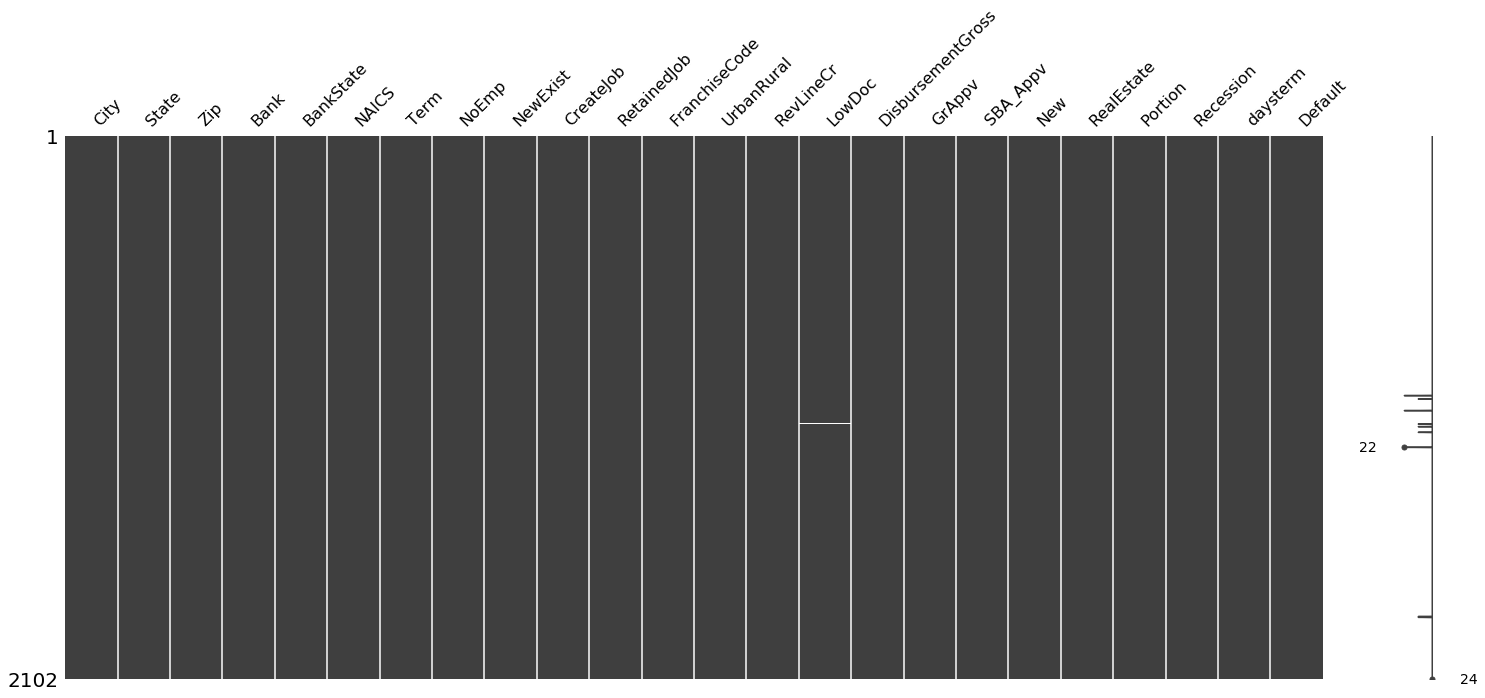

In [9]:
msno.matrix(df_case)

In [10]:
df_case.isnull().sum(axis=0)

City                 0
State                0
Zip                  0
Bank                 3
BankState            3
NAICS                0
Term                 0
NoEmp                0
NewExist             1
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            2
LowDoc               3
DisbursementGross    0
GrAppv               0
SBA_Appv             0
New                  0
RealEstate           0
Portion              0
Recession            0
daysterm             0
Default              0
dtype: int64

Vemos que temos poucos valores ausentes. Vamos removê-los:

In [11]:
df_case = df_case.dropna()

## Separação treino-teste

Antes de separar em treino e teste, verificamos o balanceamento da variável alvo. 

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Porcentagem de Default')]

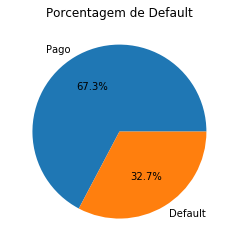

In [12]:
ax = (
    df_case["Default"]
    .astype(int)
    .map({0: "Pago", 1: "Default"})
    .value_counts()
    .plot.pie(autopct="%1.1f%%")
)
ax.set(title="Porcentagem de Default", ylabel="")

A variável alvo está desbalanceada. Por isso, vamos usar uma separação treino-teste estratificada para manter a proporção:

In [13]:
X = df_case.drop(["Default"], axis=1)
y = df_case["Default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Porcentagem de Default')]

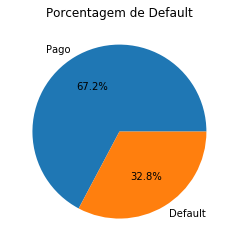

In [14]:
ax = y_train.map({0: "Pago", 1: "Default"}).value_counts().plot.pie(autopct="%1.1f%%")
ax.set(title="Porcentagem de Default", ylabel="")

## Análise Exploratória

Com o dado de teste separado, podemos realizar uma análise exploratória simples no conjunto de treino.

Vamos unir os atributos mais o alvo em um DataFrame para facilitar a análise exploratória.

In [15]:
df_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
df_train.head()

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,...,LowDoc,DisbursementGross,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,Default
LoanNr_ChkDgt,,,,,,,,,,,,,,,,,,,,,
2155836004,SUNLAND,CA,91040,WELLS FARGO BANK NATL ASSOC,SD,531210,26,1,1,1,...,N,97836.0,50000.0,25000.0,False,False,0.5,False,780,1
1960805008,NORTH HILLS,CA,91343,BANK OF AMERICA NATL ASSOC,NC,531210,62,1,1,0,...,N,34200.0,24000.0,12000.0,False,False,0.5,False,1860,1
2953176001,LOS ANGELES,CA,90004,JPMORGAN CHASE BANK NATL ASSOC,IL,531311,50,5,1,0,...,N,42478.0,30000.0,15000.0,False,False,0.5,False,1500,1
7414164010,LA MESA,CA,91942,BANK OF AMERICA NATL ASSOC,NC,531210,56,1,1,0,...,N,25000.0,25000.0,12500.0,False,False,0.5,True,1680,1
1854955003,PATTERSON,CA,95363,BANK OF AMERICA NATL ASSOC,NC,531390,38,3,1,0,...,N,18063.0,10000.0,5000.0,False,False,0.5,False,1140,1


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1569 entries, 2155836004 to 4242234006
Data columns (total 24 columns):
City                 1569 non-null object
State                1569 non-null object
Zip                  1569 non-null object
Bank                 1569 non-null object
BankState            1569 non-null object
NAICS                1569 non-null object
Term                 1569 non-null int64
NoEmp                1569 non-null int64
NewExist             1569 non-null object
CreateJob            1569 non-null int64
RetainedJob          1569 non-null int64
FranchiseCode        1569 non-null object
UrbanRural           1569 non-null object
RevLineCr            1569 non-null object
LowDoc               1569 non-null object
DisbursementGross    1569 non-null float64
GrAppv               1569 non-null float64
SBA_Appv             1569 non-null float64
New                  1569 non-null bool
RealEstate           1569 non-null bool
Portion              1569 non-null float64


Alguns atributos possuem informação redundante:

* `City`, `State` e `Zip`, que representam a localidade do tomador do empréstimo.
* `Term` e `daysterm` que indicam a duração do empréstimo e meses e dias, respectivamente.
* `MIS_Status` e `Default` que representam se o empreśtimo foi pago ou não.

In [17]:
df_train.describe()

,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,Portion,daysterm,Default
count,1569.000000,1569.000000,1569.000000,1569.000000,1.569000e+03,1.569000e+03,1.569000e+03,1569.000000,1569.000000,1569.000000
mean,127.730402,9.425112,2.607393,5.473550,2.429108e+05,2.334793e+05,1.905752e+05,0.673497,3831.912046,0.327597
std,93.880565,29.996040,8.233214,18.942433,3.365639e+05,3.427521e+05,3.000879e+05,0.187303,2816.416962,0.469487
min,0.000000,0.000000,0.000000,0.000000,4.999000e+03,5.000000e+03,2.500000e+03,0.400000,0.000000,0.000000
25%,60.000000,2.000000,0.000000,0.000000,4.000000e+04,3.000000e+04,1.500000e+04,0.500000,1800.000000,0.000000
50%,84.000000,3.000000,0.000000,2.000000,1.000000e+05,6.200000e+04,4.160000e+04,0.700000,2520.000000,0.000000
75%,240.000000,8.000000,2.000000,5.000000,3.060000e+05,3.000000e+05,2.409750e+05,0.850000,7200.000000,1.000000
max,306.000000,600.000000,130.000000,535.000000,2.315000e+06,2.350000e+06,2.115000e+06,1.000000,9180.000000,1.000000


In [18]:
df_train.describe(include=["object"])

,City,State,Zip,Bank,BankState,NAICS,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc
count,1569,1569,1569,1569,1569,1569,1569,1569,1569,1569,1569
unique,448,1,724,137,20,24,2,29,3,4,5
top,LOS ANGELES,CA,92618,BANK OF AMERICA NATL ASSOC,CA,531210,1,1,1,Y,N
freq,113,1569,13,263,741,588,1316,1068,1319,557,1533


Abaixo, vemos a correlação entre as variáveis:

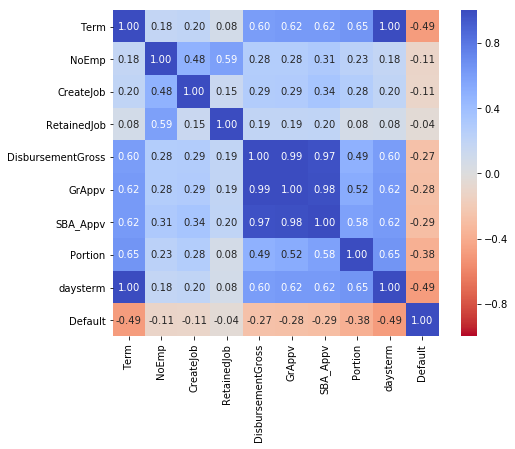

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

corr = df_train.select_dtypes(include=np.number).corr()
# mask = np.zeros_like(corr).diagonal()
# mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr, annot=True, fmt=".2f", ax=ax, square=True, cmap="coolwarm_r", vmin=-1, vmax=1
)
# ax.tick_params(colors="white")
# ax.collections[0].colorbar.ax.tick_params(colors="white")

Há algumas variáveis fortemente correlacionadas como `Term`e `daysterm`. Isso era de se esprera já que `Term` é o número de meses de duração do empréstimo e `daysterm`, o tempo em dias.

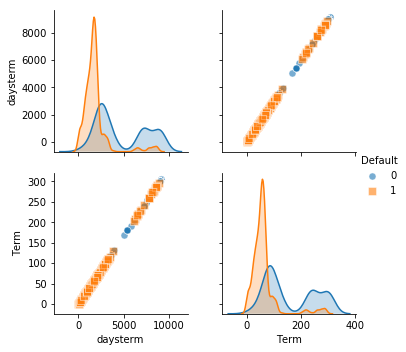

In [20]:
sns.pairplot(
    df_train,
    vars=["daysterm", "Term"],
    hue="Default",
    markers=["o", "s"],
    plot_kws=dict(s=50, alpha=0.6),
)

Outras variáveis fortemente correlacionadas são mostradas abaixo:

/home/gbra/anaconda3/envs/tech_talk/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


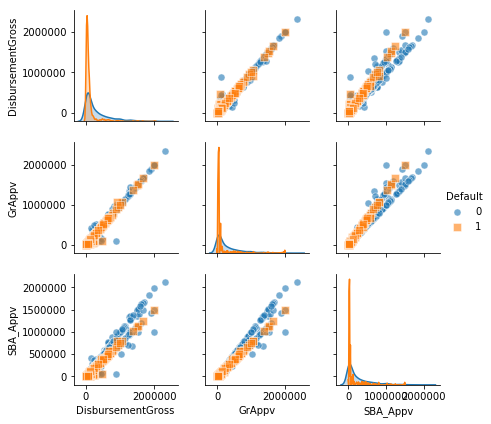

In [21]:
sns.pairplot(
    df_train,
    vars=["DisbursementGross", "GrAppv", "SBA_Appv"],
    hue="Default",
    markers=["o", "s"],
    plot_kws=dict(s=50, alpha=0.6),
    size=2,
)

## Preparando dados para Modelagem

Para a modelagem, utilizarei só algumas variáveis que foram escolhidas pela análise anterior e um pouco de bom-senso. Numa aplicação real, seria interessante usar uma metodologia mais quantitativa e/ou uma redução de dimensionalidade (e.g., PCA).

In [22]:
my_features = [
    "City",
    "Zip",
    "Bank",
    "BankState",
    "NAICS",
    "NoEmp",
    "NewExist",
    "CreateJob",
    "RetainedJob",
    "FranchiseCode",
    "UrbanRural",
    "RevLineCr",
    "LowDoc",
    "DisbursementGross",
    "GrAppv",
    "SBA_Appv",
    "New",
    "RealEstate",
    "Portion",
    "Recession",
    "Term",
]
X_train[my_features].iloc[0]

City                                     SUNLAND
Zip                                        91040
Bank                 WELLS FARGO BANK NATL ASSOC
BankState                                     SD
NAICS                                     531210
NoEmp                                          1
NewExist                                       1
CreateJob                                      1
RetainedJob                                    2
FranchiseCode                                  1
UrbanRural                                     1
RevLineCr                                      Y
LowDoc                                         N
DisbursementGross                          97836
GrAppv                                     50000
SBA_Appv                                   25000
New                                        False
RealEstate                                 False
Portion                                      0.5
Recession                                  False
Term                

Em seguida, criamos alguns estimadores para compor o nosso pipeline de pré-processamento.

In [23]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(
                "The DataFrame does not include the columns: %s" % cols_error
            )


class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=self.dtype)


class NotNanSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=self.dtype)

Em seguida, definimos o pipeline de préprocessamento:

1. Seleciona apenas as variáveis de interesse:
2. Para as variáveis numéricas, padroniza com MinMaxScaler.
3. Para as variáveis categóricas, aplica one-hot encoding.

In [24]:
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=my_features),
    FeatureUnion(
        transformer_list=[
            (
                "numeric_features",
                make_pipeline(TypeSelector(np.number), MinMaxScaler()),
            ),
            (
                "categorical_features",
                make_pipeline(
                    TypeSelector(["object", bool]),
                    OneHotEncoder(handle_unknown="ignore"),
                ),
            ),
        ]
    ),
)

## Modelagem

Para a modelagem, escolhi os seguintes modelos:
* Aleatório (se bem que não podemos chamá-lo de modelo...)
* Regressão Logística
* Support Vector Classifier
* Random Forests
* XGBoost

E estarei utilizando Validação Cruzada com Grid Search para otimização dos hiper-parâmetros. Estarei otimizando a métrica Recall pois meu objetivo é priorizar os inadimplentes diminuindo os falsos negativos.

In [25]:
# Constantes

K_FOLDS = 3  # Número de dobras na Validação Cruzada

### Dummy Classifier - Random

In [26]:
param_grid = [{"clf__strategy": ["uniform"]}]

random_pipeline = Pipeline(
    steps=[("pre", preprocess_pipeline), ("clf", DummyClassifier(random_state=42))]
)


random_clf = GridSearchCV(
    random_pipeline, param_grid, scoring="recall", cv=K_FOLDS, n_jobs=-1
)
random_clf.fit(X_train, y_train.values)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        Pipeline(memory=None,
                                                 steps=[('columnselector',
                                                         ColumnSelector(columns=['City',
                                                                                 'Zip',
                                                                                 'Bank',
                                                                                 'BankState',
                                                                                 'NAICS',
                                                                                 'NoEmp',
                                                                                 'NewExist',
                                                                                 'Crea

In [27]:
show_best_results(random_clf)

Recall of 0.514 for {'clf__strategy': 'uniform'}


              precision    recall  f1-score   support

           0       0.67      0.49      0.56      1055
           1       0.33      0.51      0.40       514

    accuracy                           0.50      1569
   macro avg       0.50      0.50      0.48      1569
weighted avg       0.56      0.50      0.51      1569



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc05febb00>)

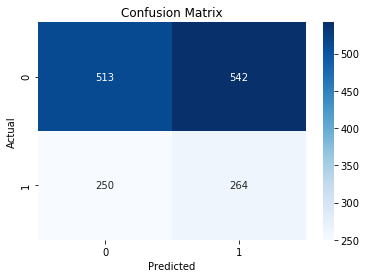

In [28]:
report(random_clf.best_estimator_, X_train, y_train.values)

### Regressão Logística

In [29]:
%%time
param_grid = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": np.logspace(-3, 3, 7),
    "clf__solver": ["liblinear"],
}

logit_pipeline = Pipeline(
    steps=[
        ("pre", preprocess_pipeline),
        ("clf", LogisticRegression(random_state=42)),
    ]
)


logit_clf = GridSearchCV(
    logit_pipeline, param_grid, scoring="recall", cv=K_FOLDS, n_jobs=-1
)
logit_clf.fit(X_train, y_train.values)

CPU times: user 829 ms, sys: 77 ms, total: 906 ms
Wall time: 4.43 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        Pipeline(memory=None,
                                                 steps=[('columnselector',
                                                         ColumnSelector(columns=['City',
                                                                                 'Zip',
                                                                                 'Bank',
                                                                                 'BankState',
                                                                                 'NAICS',
                                                                                 'NoEmp',
                                                                                 'NewExist',
                                                                                 'Crea

In [30]:
show_best_results(logit_clf)

Recall of 0.803 for {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}


In [31]:
grid_results(logit_clf, "clf__C", "clf__penalty")

param_clf__penalty,l1,l2
param_clf__C,,
0.001,0,0
0.01,0,0.426
0.1,0.584,0.652
1.0,0.803,0.712
10.0,0.778,0.72
100.0,0.751,0.737
1000.0,0.716,0.726


              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1055
           1       0.82      0.80      0.81       514

    accuracy                           0.88      1569
   macro avg       0.86      0.86      0.86      1569
weighted avg       0.88      0.88      0.88      1569



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc27f7de80>)

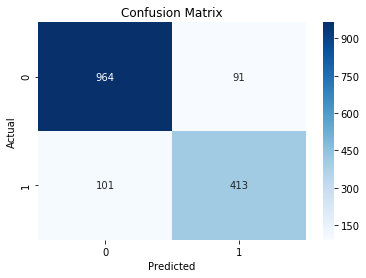

In [32]:
report(logit_clf.best_estimator_, X_train, y_train.values)

### Support Vector Classifier

In [33]:
param_grid = {"clf__gamma": np.logspace(-5, 0, 6), "clf__C": np.logspace(3, 11, 9)}

svc_pipeline = Pipeline(
    steps=[("pre", preprocess_pipeline), ("clf", SVC(random_state=42))]
)


svc_clf = GridSearchCV(
    svc_pipeline, param_grid, scoring="recall", cv=K_FOLDS, n_jobs=-1
)
svc_clf.fit(X_train, y_train.values)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        Pipeline(memory=None,
                                                 steps=[('columnselector',
                                                         ColumnSelector(columns=['City',
                                                                                 'Zip',
                                                                                 'Bank',
                                                                                 'BankState',
                                                                                 'NAICS',
                                                                                 'NoEmp',
                                                                                 'NewExist',
                                                                                 'Crea

In [34]:
show_best_results(svc_clf)

Recall of 0.831 for {'clf__C': 10000.0, 'clf__gamma': 0.1}


In [35]:
grid_results(svc_clf, "clf__C", "clf__gamma")

param_clf__gamma,1e-05,0.0001,0.001,0.01,0.1,1.0
param_clf__C,,,,,,
1000.0,0.584,0.739,0.743,0.761,0.819,0.113
10000.0,0.739,0.741,0.755,0.796,0.831,0.113
100000.0,0.741,0.757,0.749,0.803,0.831,0.113
1000000.0,0.755,0.739,0.751,0.803,0.831,0.113
10000000.0,0.718,0.72,0.751,0.803,0.831,0.113
100000000.0,0.706,0.72,0.751,0.803,0.831,0.113
1000000000.0,0.702,0.72,0.751,0.803,0.831,0.113
10000000000.0,0.708,0.72,0.751,0.803,0.831,0.113
100000000000.0,0.708,0.72,0.751,0.803,0.831,0.113


              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1055
           1       0.83      0.83      0.83       514

    accuracy                           0.89      1569
   macro avg       0.87      0.87      0.87      1569
weighted avg       0.89      0.89      0.89      1569



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc27e45a58>)

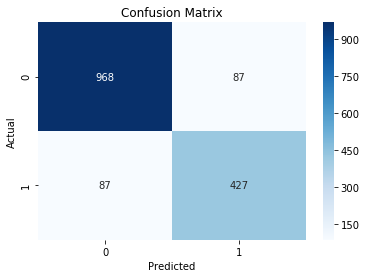

In [36]:
report(svc_clf.best_estimator_, X_train, y_train.values)

### RandomForests

In [37]:
param_grid = {
    "clf__n_estimators": [50, 100, 150],  # Qtde de Árvores na floresta
    "clf__max_depth": [10, 20, 30, None],  # Profunidade da árvore
    "clf__max_features": [0.1, 0.2, 0.3, None],
}

rf_pipeline = Pipeline(
    steps=[
        ("pre", preprocess_pipeline),
        ("clf", RandomForestClassifier(random_state=42)),
    ]
)


rf_clf = GridSearchCV(rf_pipeline, param_grid, scoring="recall", cv=K_FOLDS, n_jobs=-1)
rf_clf.fit(X_train, y_train.values)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        Pipeline(memory=None,
                                                 steps=[('columnselector',
                                                         ColumnSelector(columns=['City',
                                                                                 'Zip',
                                                                                 'Bank',
                                                                                 'BankState',
                                                                                 'NAICS',
                                                                                 'NoEmp',
                                                                                 'NewExist',
                                                                                 'Crea

In [38]:
show_best_results(rf_clf)

Recall of 0.870 for {'clf__max_depth': 20, 'clf__max_features': 0.2, 'clf__n_estimators': 100}


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1055
           1       0.90      0.87      0.89       514

    accuracy                           0.93      1569
   macro avg       0.92      0.91      0.92      1569
weighted avg       0.93      0.93      0.93      1569



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc27dc2f98>)

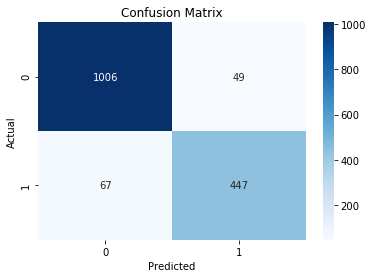

In [39]:
report(rf_clf.best_estimator_, X_train, y_train.values)

### XGBoost

In [40]:
param_grid = {
    "clf__n_estimators": np.linspace(25, 200, 8).astype(int),
    "clf__max_depth": np.linspace(1, 10, 10).astype(int),
}


xgboost_pipeline = Pipeline(
    steps=[("pre", preprocess_pipeline), ("clf", XGBClassifier(random_state=42))]
)


xgboost_clf = GridSearchCV(
    xgboost_pipeline, param_grid, scoring="recall", cv=K_FOLDS, n_jobs=-1
)
xgboost_clf.fit(X_train, y_train.values)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        Pipeline(memory=None,
                                                 steps=[('columnselector',
                                                         ColumnSelector(columns=['City',
                                                                                 'Zip',
                                                                                 'Bank',
                                                                                 'BankState',
                                                                                 'NAICS',
                                                                                 'NoEmp',
                                                                                 'NewExist',
                                                                                 'Crea

In [41]:
show_best_results(xgboost_clf)

Recall of 0.922 for {'clf__max_depth': 5, 'clf__n_estimators': 150}


In [42]:
grid_results(xgboost_clf, "clf__n_estimators", "clf__max_depth")

param_clf__max_depth,1,2,3,4,5,6,7,8,9,10
param_clf__n_estimators,,,,,,,,,,
25,0.87,0.854,0.881,0.887,0.897,0.909,0.903,0.905,0.901,0.903
50,0.868,0.864,0.883,0.895,0.909,0.909,0.907,0.907,0.914,0.91
75,0.858,0.87,0.893,0.912,0.907,0.914,0.912,0.912,0.912,0.912
100,0.858,0.883,0.899,0.909,0.916,0.914,0.91,0.909,0.91,0.91
125,0.854,0.897,0.901,0.916,0.92,0.918,0.914,0.907,0.91,0.912
150,0.852,0.903,0.909,0.916,0.922,0.916,0.91,0.907,0.91,0.909
175,0.852,0.912,0.91,0.912,0.918,0.912,0.91,0.909,0.91,0.909
200,0.856,0.912,0.914,0.909,0.914,0.912,0.912,0.909,0.912,0.907


              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1055
           1       0.90      0.92      0.91       514

    accuracy                           0.94      1569
   macro avg       0.93      0.94      0.93      1569
weighted avg       0.94      0.94      0.94      1569



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc27d10470>)

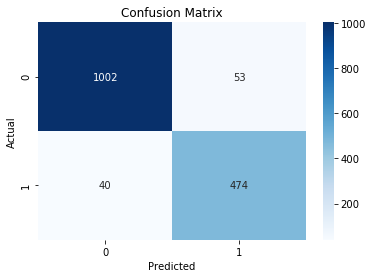

In [43]:
report(xgboost_clf.best_estimator_, X_train, y_train.values)

### Resumo dos modelos

In [44]:
models = {
    "Random": random_clf,
    "Logit": logit_clf,
    "Random Forests": rf_clf,
    "XGBoost": xgboost_clf,
    "SVC": svc_clf,
}

In [45]:
%%time

models_best_scores = {
    name: cross_val_score(
        model, X_train, y_train.values, scoring="recall", cv=K_FOLDS, n_jobs=-1
    ).mean()
    for name, model in models.items()
}

CPU times: user 437 ms, sys: 231 ms, total: 668 ms
Wall time: 5min 2s


In [46]:
pd.Series(models_best_scores).rename("Recall").sort_values(
    ascending=False
).to_frame().round(3).style.background_gradient()

,Recall
XGBoost,0.909
Random Forests,0.86
SVC,0.801
Logit,0.778
Random,0.514


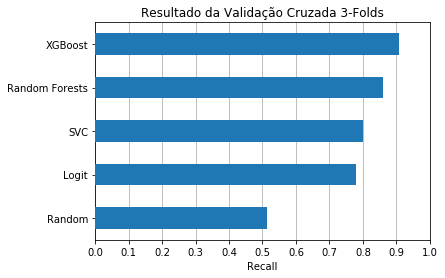

In [47]:
ax = pd.Series(models_best_scores).sort_values(ascending=True).plot.barh(zorder=5)
ax.set(
    xlabel="Recall",
    title=f"Resultado da Validação Cruzada {K_FOLDS}-Folds",
    xlim=[0, 1],
    xticks=np.arange(0, 1.1, 0.1),
)
ax.grid(axis="x", zorder=0)

In [48]:
best_model = models[
    max(models_best_scores.keys(), key=(lambda key: models_best_scores[key]))
]

## Teste

Hora de utilizar o dataset de teste. Vamos utilizar o nosso melhor modelo para prever a inadimplência. Em seguida, iremos comparar com o resultado real.

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       353
           1       0.92      0.91      0.91       171

    accuracy                           0.94       524
   macro avg       0.94      0.94      0.94       524
weighted avg       0.94      0.94      0.94       524



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc27c016a0>)

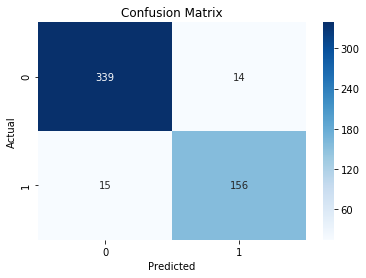

In [49]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test.values, y_pred))
display(confusion_matrix_vis(y_test.values, y_pred))

De 524, conseguimos acertar 94%. Aprovaríamos 15 empréstimos que se tornariam inadimplentes (falsos negativos) e negaríamos 14 empréstimos de bons pagadores (falsos positivos).

Podemos também calcular a probabilidade de inadimplência.

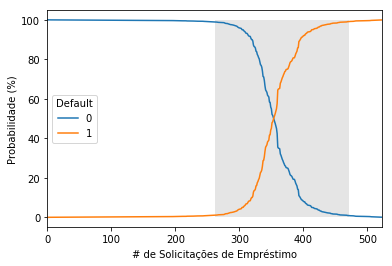

In [50]:
y_pred_proba = (
    pd.DataFrame(best_model.predict_proba(X_test))
    .sort_values([1])
    .reset_index(drop=True)
)

fig, ax = plt.subplots()
(y_pred_proba * 100).reset_index(drop=True).plot.line(ax=ax)

ax.legend(title="Default")

ax.set(xlabel="# de Solicitações de Empréstimo", ylabel="Probabilidade (%)")

ax.axhspan(0, 100, 0.5, 0.9, facecolor="0.5", alpha=0.2)

A faixa em cinza aponta os empréstimos em que o modelo não é 100% preciso.

## Referências 

* https://www.tandfonline.com/doi/full/10.1080/10691898.2018.1434342
* https://ramhiser.com/post/2018-04-16-building-scikit-learn-pipeline-with-pandas-dataframe/
* http://www.xavierdupre.fr/app/mlinsights/helpsphinx/notebooks/visualize_pipeline.html